In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
# ###### requirment 1
def UniformQuantizer(in_val, n_bits, xmax, m):
    """
    uniform quantizer
    Parameters:
    in_val : vector of samples
    n_bits : # of bits to store the level
    xmax : max value in samples values
    m : 0 -> midrise, 1 -> midtread
    return:
    vector of levels to each sample
    """
    levels = 2 ** n_bits
    delta = 2 * xmax / levels
    x_min = xmax - (delta - ((1 - m) * 0.5*delta))
    q_ind = np.zeros(len(in_val))
    
    in_val = [- x_min if value < -x_min else value for value in in_val]
    
    q_ind = [(value + x_min) // delta for value in in_val]
    
    return [ q_ind[i]+1 if (in_val[i] + x_min) % delta > 0.5*delta else q_ind[i] for i in range( len(in_val))  ]    
###### requirment 1
# def UniformQuantizer(in_val, n_bits, xmax, m):
#     """
#     uniform quantizer
#     Parameters:
#     in_val : vector of samples
#     n_bits : # of bits to store the level
#     xmax : max value in samples values
#     m : 0 -> mibrise, 1 -> midtread
#     return:
#     out_levels : vector of levels to each sample
#     """
#     levels = 1 << n_bits
#     delta = 2 * xmax / levels
#     delta_over_2 = delta / 2
#     x_min = xmax - (delta - ((1 - m) * delta_over_2))
#     out_levels = np.zeros(len(in_val))
#     i = 0
#     for value in in_val:
#         if(value < -x_min):
#             value = -x_min
#         error = (value + x_min) % delta
#         out_levels[i] = (value + x_min) // delta
#         if(error > delta_over_2):
#             out_levels[i] = out_levels[i] + 1
#         i = i + 1
#     return out_levels

In [3]:
###### requirment 2
def UniformDequantizer(q_ind, n_bits, xmax, m):
    """
    uniform dequantizer (match level index with it's value)
    Parameters:
    q_ind : vector of levels to each sample
    n_bits : # of bits to store the level
    xmax : max value in samples values
    m : 0 -> midrise, 1 -> midtread
    return:
    vector of values corresponding to each level
    """
    levels = 2 ** n_bits
    delta = 2 * xmax / levels
    x_min = xmax - (delta - ((1 - m) * 0.5*delta))
    
    return  (np.array(q_ind) * delta ) - x_min
    


In [4]:
#needed function 
def calc_SNR(samples, q_levels, n_bits, u, max_value):
    """
    calculate theoretical and experimental SNR
    Parameters:
    samples : vector of function samples 
    q_levels : vector of quantized samples
    n_bits : number of bits to decode the level
    u : expanding coefficient
    max_value : max value in samples
    return:
    SNR_theoretical : calculate the SNR with the equation
    SNR_experimental : calculate the SNR from the real values
    """
    error_diff = np.subtract(samples, q_levels)
    input_power = np.mean(np.square(samples))
    if(u > 0):
        SNR_theoretical = (3 * (1 << n_bits)**2) / (np.log(1 + u) ** 2)
    else: #uniform quantization
        SNR_theoretical = (3 * (1 << n_bits)**2 * input_power) / max_value**2
    SNR_experimental = input_power / np.mean(np.square(error_diff))
    return SNR_theoretical, SNR_experimental

def rand_exp(n, max_value):
    """
    generate randam samples with exponential probability for value and binary probability for sign
    Parameters:
    n : size of vector
    max_value : max value in samples
    return:
    out_vect : vector of random values 
    """
    out_vect = np.random.exponential(1, n)
    out_vect /= np.amax(out_vect)
    signs = np.random.choice([-1, 1], size=(n,), p=[1./2, 1./2])
    out_vect *= (max_value * signs)
    return out_vect

def compressing_block(samples, u):
    """
    this expanding samples with log function to apply non-uniform quantizer
    Parameters:
    samples : vector of function samples
    max_value : max value in samples
    u : expanding coefficient
    return:
    y : vector of expanding samples
    """
    y = np.zeros_like(samples)
    if(u > 0):
        y = np.sign(samples) * np.log(1 + u * np.absolute(samples)) / np.log(1 + u)
    else: 
        y = np.copy(samples)
    return y

def expanding_block(expanded_samples, u):
    """
    this compressing expanded samples to it's initial values
    Parameters:
    expanded_samples : vector of function expanded samples
    max_value : max value in samples
    u : expanding coefficient
    return:
    x : vector of real samples' value
    """
    x = np.zeros_like(expanded_samples)
    if(u > 0):
        x = ((1 + u) ** np.absolute(expanded_samples) - 1) / u
        x *= (np.sign(expanded_samples))
    else : 
        x = np.copy(expanded_samples)
    return x

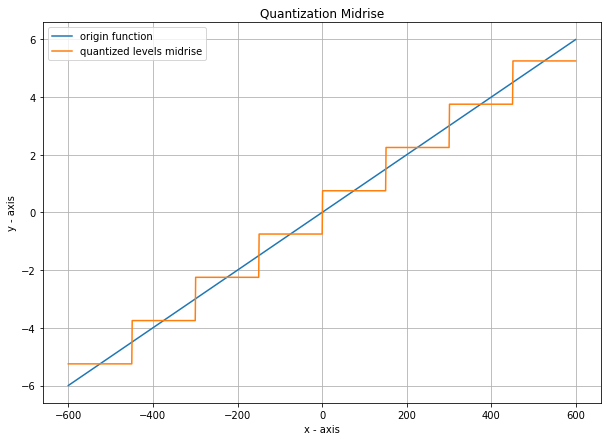

In [5]:
###### requirment 3

# initialize vector of samples
x = np.arange(start=-6, stop=6, step=0.01)

# calculate quntization level for each samples (midrise)
q_level_midrise = UniformQuantizer(x, 3, 6, 0)
values_midrise = UniformDequantizer(q_level_midrise, 3, 6, 0)

#ploting
plt.figure(figsize=(10,7))
plt.plot(range(-len(x)//2, len(x)//2), x, label = "origin function")
plt.plot(range(-len(x)//2, len(x)//2), values_midrise, label = "quantized levels midrise")

plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Quantization Midrise')

plt.legend()
plt.grid()
plt.show()

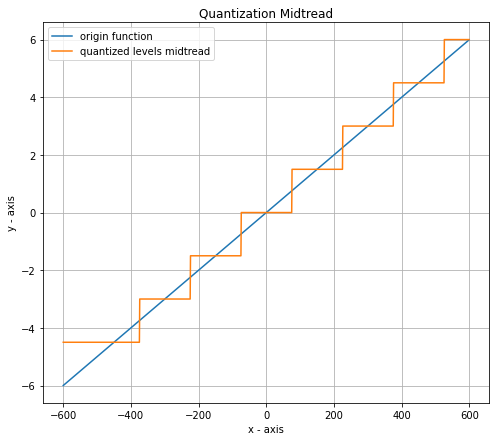

In [6]:
# calculate quntization level for each samples (midtread)
q_level_midtread = UniformQuantizer(x, 3, 6, 1)
values_midtread = UniformDequantizer(q_level_midtread, 3, 6, 1)

#ploting
plt.figure(figsize=(8,7))
plt.plot(range(-len(x)//2, len(x)//2), x, label = "origin function")
plt.plot(range(-len(x)//2, len(x)//2), values_midtread, label = "quantized levels midtread")

plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Quantization Midtread')

plt.legend()
plt.grid()
plt.show()

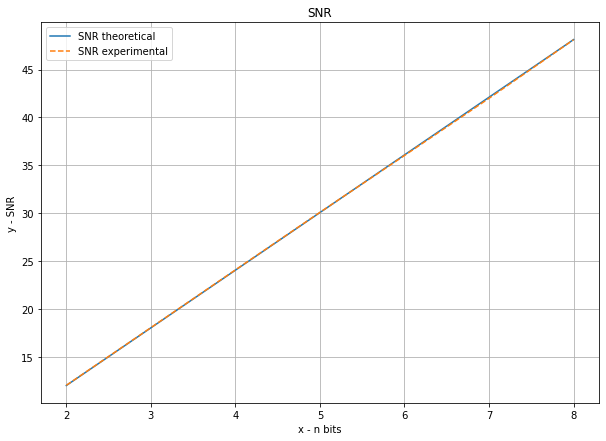

In [7]:
###### requirment 4
# calculate random samples
samples = np.random.uniform(low=-5, high=5, size=10000)

SNR_theoretical = np.zeros(7)
SNR_experimental = np.zeros(7)

for i in range(2, 9):
    # calculate quntization level for each samples (midrise)
    q_levels = UniformDequantizer(UniformQuantizer(samples, i, 5, 0), i, 5, 0)
    SNR_theoretical[i - 2], SNR_experimental[i - 2] = calc_SNR(samples, q_levels, i, 0, 5)

#ploting
plt.figure(figsize=(10,7))
plt.plot(range(2, 9), 10*np.log10(SNR_theoretical), label = "SNR theoretical")
plt.plot(range(2, 9), 10*np.log10(SNR_experimental), "--", label = "SNR experimental")

plt.xlabel('x - n bits')
plt.ylabel('y - SNR')
plt.title('SNR')

plt.legend()
plt.grid()
plt.show()

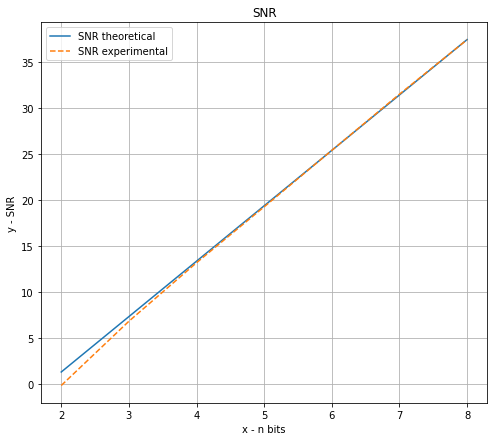

In [8]:
###### requirment 5
samples = np.array(rand_exp(10000, 5) ) 
# signs = np.array( [random.choice([-1, 1]) for _ in range(10000)])
# samples = samples * signs
# print(len(samples[samples<0]))
SNR_theoretical = np.zeros(7)
SNR_experimental = np.zeros(7)

for i in range(2, 9):
    # calculate quntization level for each samples (midrise)
    q_levels = UniformDequantizer(UniformQuantizer(samples, i, 5, 0), i, 5, 0)
    SNR_theoretical[i - 2], SNR_experimental[i - 2] = calc_SNR(samples, q_levels, i, 0, 5)

#ploting
plt.figure(figsize=(8,7))
plt.plot(range(2, 9), 10*np.log10(SNR_theoretical), label = "SNR theoretical")
plt.plot(range(2, 9), 10*np.log10(SNR_experimental),"--", label = "SNR experimental")

plt.xlabel('x - n bits')
plt.ylabel('y - SNR')
plt.title('SNR')

plt.legend()
plt.grid()
plt.show()


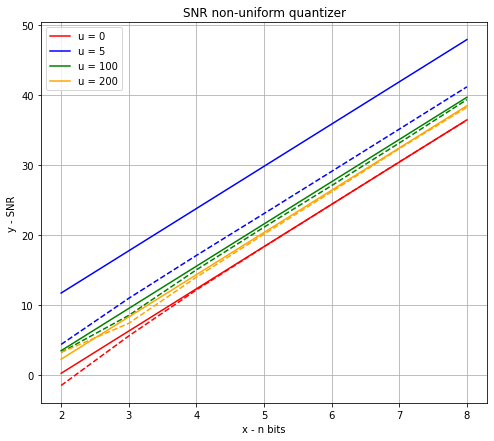

In [9]:
###### requirment 6
plt.figure(figsize=(8,7))
samples = rand_exp(10000, 1) 
colors = ['red', 'blue', 'green', 'orange']
j = 0

for u in [0, 5, 100, 200]:
    expanded_samples = compressing_block(samples, u)

    SNR_theoretical = np.zeros(7)
    SNR_experimental = np.zeros(7)

    for i in range(2, 9):
        # calculate quntization level for each samples (midrise)
        expanded_levels = UniformDequantizer(UniformQuantizer(expanded_samples, i, 1, 0), i, 1, 0)
        q_levels = expanding_block(expanded_levels, u)
        SNR_theoretical[i - 2], SNR_experimental[i - 2] = calc_SNR(samples, q_levels, i, u, 1)


    #ploting
    plt.plot(range(2, 9), 10*np.log10(SNR_theoretical), label = "u = " + str(u), color = colors[j])
    plt.plot(range(2, 9), 10*np.log10(SNR_experimental), "--",  color = colors[j])
    j += 1

plt.xlabel('x - n bits')
plt.ylabel('y - SNR')
plt.title('SNR non-uniform quantizer')

plt.legend()
plt.grid()
plt.show()
